In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.3 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.8.2 louvain==0.7.0


### Pre-processing Granja et al 2019 data

Data was downloaded as rds files either from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139369) or from their [GitHub](https://github.com/GreenleafLab/MPAL-Single-Cell-2019). See `../rscripts/pre_processing_granja.R` for pre-pre-processing steps that produced these files. 

In [34]:
# read in data
adata = sc.read('../data/granja/gran_rna.mtx') # rna expression matrix
adata.var_names = pd.read_csv('../data/granja/gran_rna_genes.csv', sep='\t')['gene_symbol'] # gene names
meta = pd.read_csv('../data/granja/gran_rna_meta.csv', sep='\t') # metadata
meta['bc'] = meta['Group'] + ':' + meta['Barcode'] # need to update barcode index to match ADT files
meta.index = meta['bc']
adt  = pd.read_csv('../data/granja/gran_adt_clr.csv', sep='\t') # read in ADT data
adt.fillna(0, inplace = True) # replace NAs with 0s
adata.obs_names = meta['bc'] # set obs names
adata.obs = pd.concat([meta, adt], axis=1) # add metadata to adata object
adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/home/sennis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


AnnData object with n_obs × n_vars = 20778 × 20287
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'BioClassification', 'Barcode', 'bc', 'ADT_CD10', 'ADT_CD123', 'ADT_CD14', 'ADT_CD19', 'ADT_CD3', 'ADT_CD33', 'ADT_CD34', 'ADT_CD38', 'ADT_CD4', 'ADT_CD45RA', 'ADT_CD7', 'ADT_CD8A', 'ADT_CD90', 'ADT_CD15', 'ADT_CD16', 'ADT_CD56', 'ADT_CD25', 'ADT_CD45RO', 'ADT_PD.1', 'ADT_TIGIT', 'ADT_CD127'

This dataset comes with some metadata such as UMAP coordinates and BioClassification (cell type labels). The ADT expression values are CLR normalised but the RNA is still in raw counts.

... storing 'Group' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical
... storing 'BioClassification' as categorical
... storing 'Barcode' as categorical


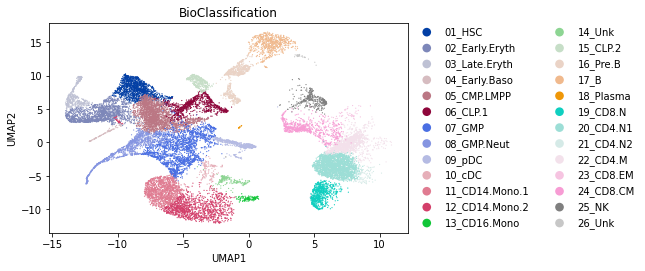

In [3]:
sc.pl.scatter(adata, x='UMAP1', y='UMAP2', color='BioClassification')

To confirm the cell type labels that come with this dataset, I compiled the following table that shows which of the proteins included in this study should be expressed by which cell types. Not all of the cell types they've included can be identified using only these 21 proteins and they probably also used gene expression to identify cell types but a lot of the main categories can be picked out fairly easily.

All leukocytes are positive for CD45. 

CD45RA and RO are splice variants of CD45.

| Cell type | Markers |
|----------|----------|
|HSC | CD34+, CD38-, CD90+ |
|Myeloid Progenitors | CD34+, CD38+, CD33+ |
|Lymphoid Progenitors | CD34+, CD38+, CD10+ |
|Erythroid Progenitors | CD34+, CD38+, CD45RA+ |
|GMP | CD34+, CD38+, CD33+, CD15+ |
|Neutrophils | CD34+, CD38+, CD33+ | 
|Eosinophils | CD34+, CD38+, CD33+, CD123+ |
|Basophils | CD34+, CD38+, CD33+, CD123+ |
|CD14 Monocytes | CD34-, CD14+, CD33+, CD15+, CD45RA+ |
|CD16 Monocytes | CD34-, CD16+, CD33+, CD15+, CD45RA+ |
|Conventional Dendritic Cells | CD45RA+, CD4+ |
|Plasmacytoid Dendritic Cells | CD45RA+, CD4+, CD123+ |
|B Cells | CD45RA+, CD19+ |
|All T Cells | CD3+ |
|CD4 Naive T Cells | CD45RA+, CD4+, CD127+, CD45RO-, CD25- |
|CD4 Central Memory T Cells | CD4+, CD25+, CD45RA-, CD45RO+, CD127+ |
|CD4 Effector Memory T Cells | CD4+, CD25-, CD45RA-, CD45RO+, CD127+ |
|CD8 Naive T Cells | CD8A+, CD45RA+, CD45RO- |
|CD8 Central Memory T Cells | CD8A+, CD45RA-, CD45RO+, TIGIT+ |
|CD8 Effector Memory T Cells | CD8A+, CD45RA-, CD45RO+ |
|NK Cells | CD56+, CD3-, TIGIT+ |

In [4]:
# create df for visualisatin
df = pd.concat([adata.obs['BioClassification'], adt], axis = 1)

/home/sennis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




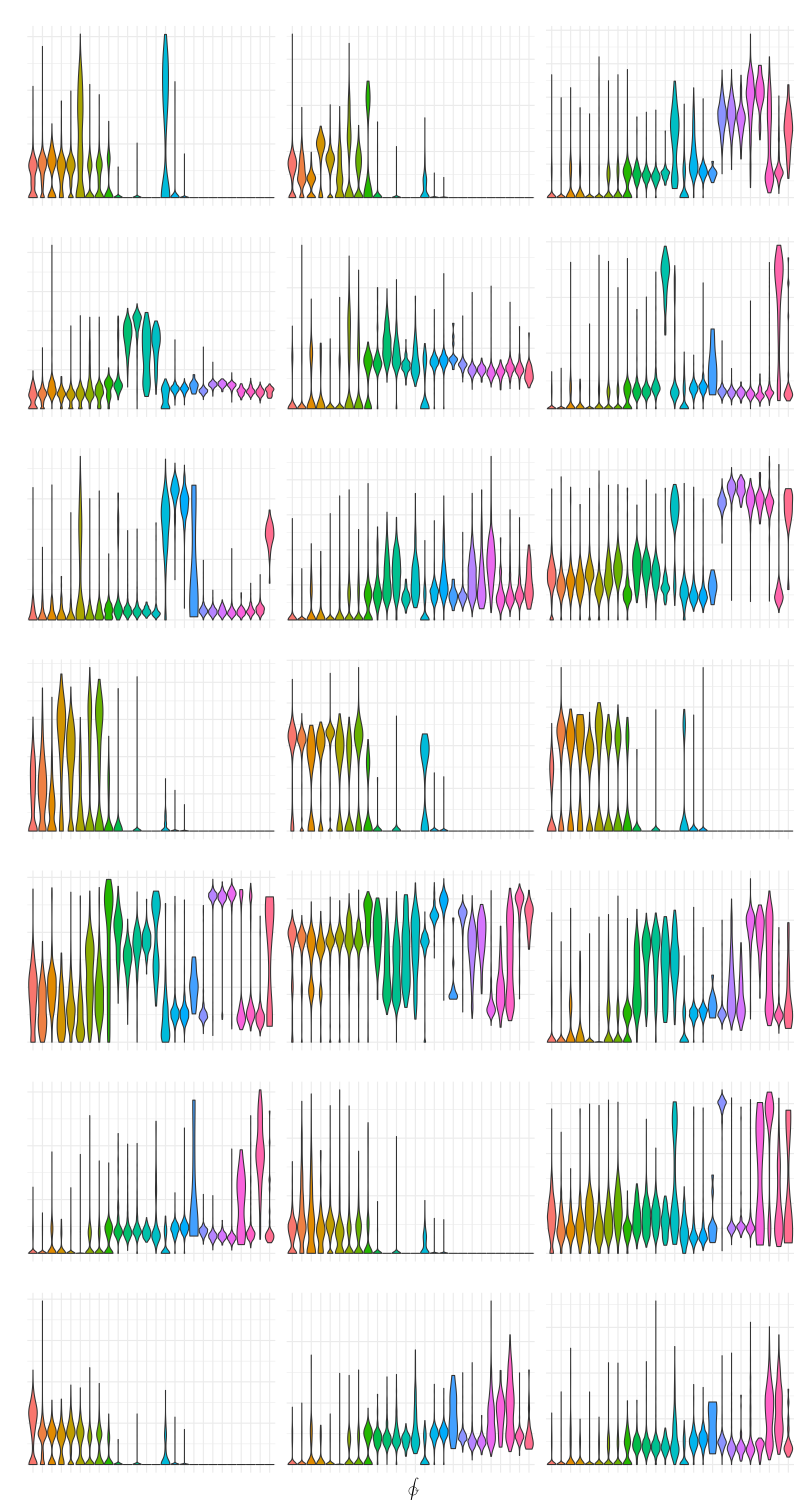

In [5]:
%%R -i df -h 1500 -w 800
library(ggplot2)
library(dplyr)
library(tidyr)

# check which cell types the different proteins are being expressed in
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = BioClassification, y = value, fill = BioClassification)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~Protein, scales = 'free', nrow = 7) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

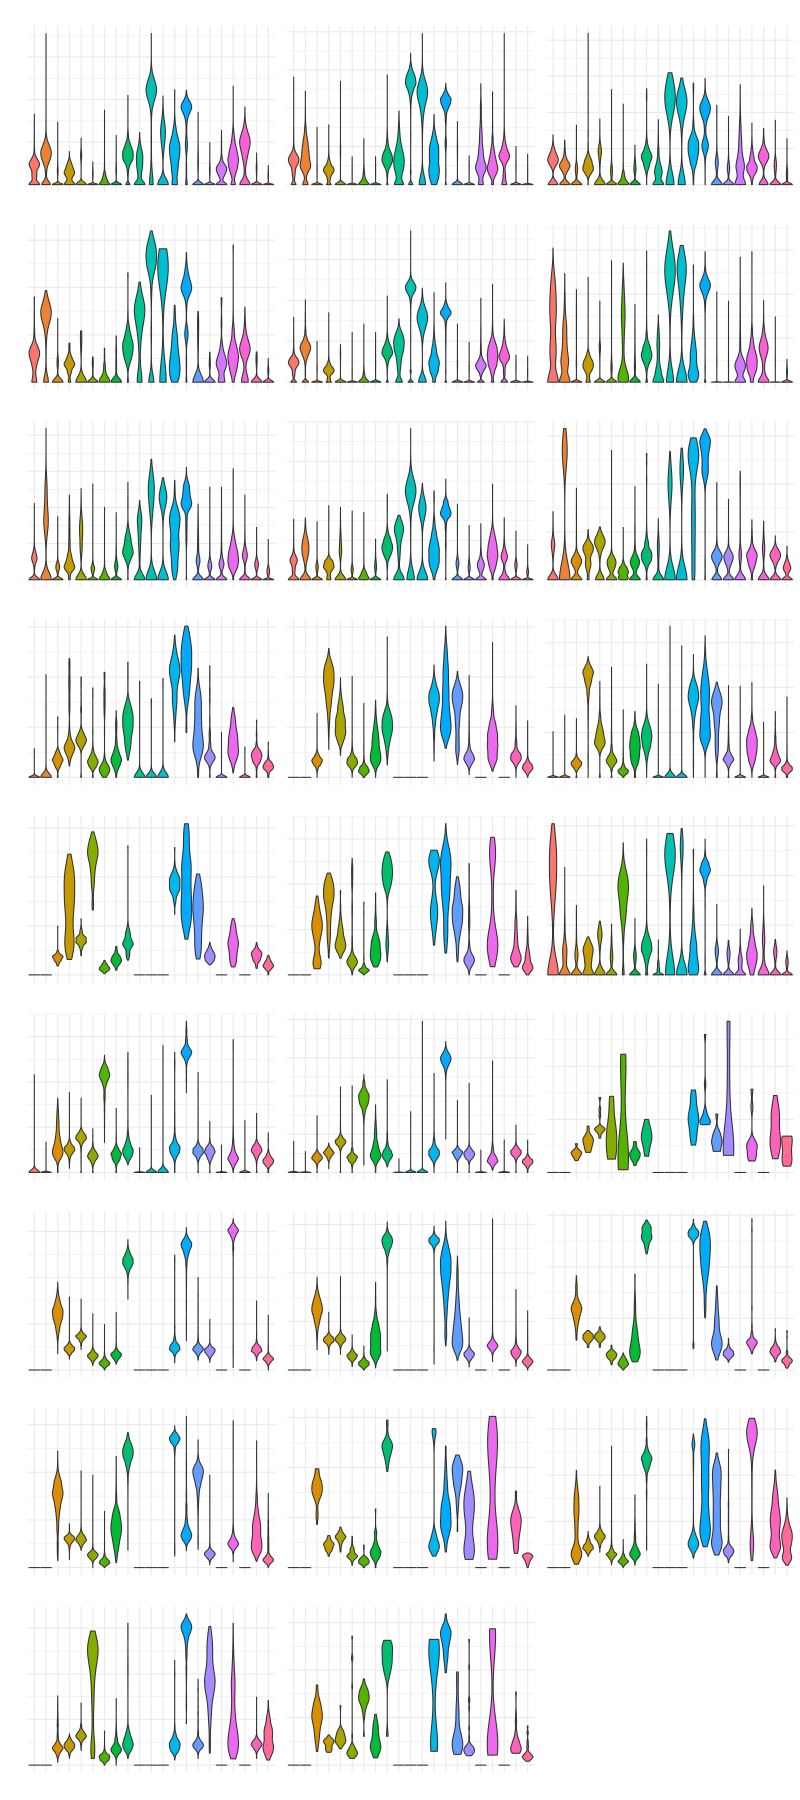

In [6]:
%%R -i df -h 1800 -w 800

# check which proteins are being expressed in each cell type
df <- df %>% pivot_longer(2:ncol(df), names_to = 'Protein')
ggplot(df, aes(x = Protein, y = value, fill = Protein)) +
    geom_violin(scale = 'width', show.legend = F) +
    facet_wrap(~BioClassification, scales = 'free', nrow = 9) +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

All cell type labels look really good so far. Seeing as I'm going to be using this dataset as my 'Gold Standard' for predicting cell type labels in other datasets, I want to see if I can identify the two categories they have listed as '14_Unk' and '26_Unk'. I also want to see if it's possible to identify more T cell categories such as Tregs.

In [7]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/sennis/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/sennis/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
running Leiden clustering


/home/sennis/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/sennis/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/sennis/anaconda3/lib/python3.7/site-packages/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


    finished: found 21 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:05)


In [8]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [9]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: 'BiocGenerics'


R[write to console]: The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from 'package:Matrix':

    which


R[write to console]: The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


R[write to console]: The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


In [10]:
#Delete adata_pp
del adata_pp

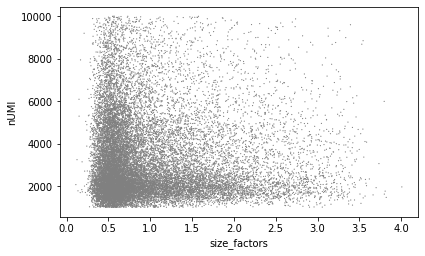

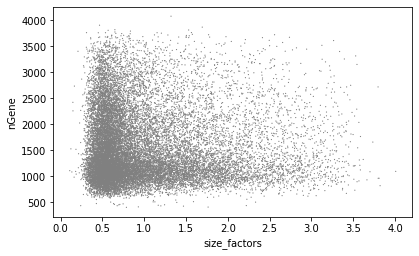

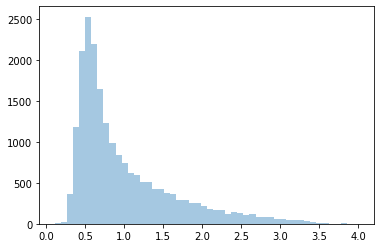

In [12]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'nUMI')
sc.pl.scatter(adata, 'size_factors', 'nGene')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [13]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [14]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
adata.X = sp.sparse.csr_matrix(adata.X)
sc.pp.log1p(adata)

In [15]:
adata.raw = adata

In [26]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000)


extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


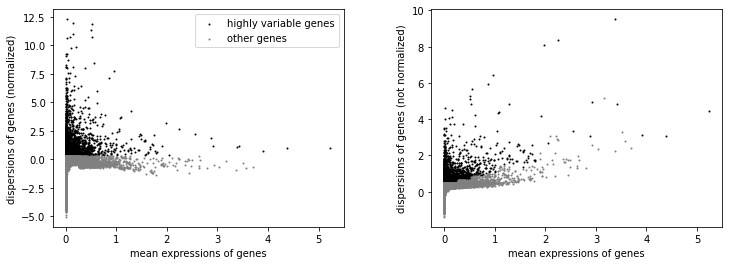

In [28]:
sc.pl.highly_variable_genes(adata)

In [29]:
adata.var[adata.var['dispersions_norm'] > 8]

,highly_variable,means,dispersions,dispersions_norm
gene_symbol,,,,
TMCC2,True,0.018949,3.123447,8.023562
APOD,True,0.002104,3.195760,8.233281
CXCL10,True,0.003984,3.463588,9.010026
GYPB,True,0.105692,3.705084,9.710403
GYPA,True,0.151794,4.129549,10.941422
ARHGEF28,True,0.002750,3.536881,9.222588
PRSS1,True,0.030619,3.526659,9.192942
ALAS2,True,0.148519,4.477148,11.949513
DEFA4,True,0.001874,3.143430,8.081515


ranking genes
    finished: added to `.uns['rank_genes_unk']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


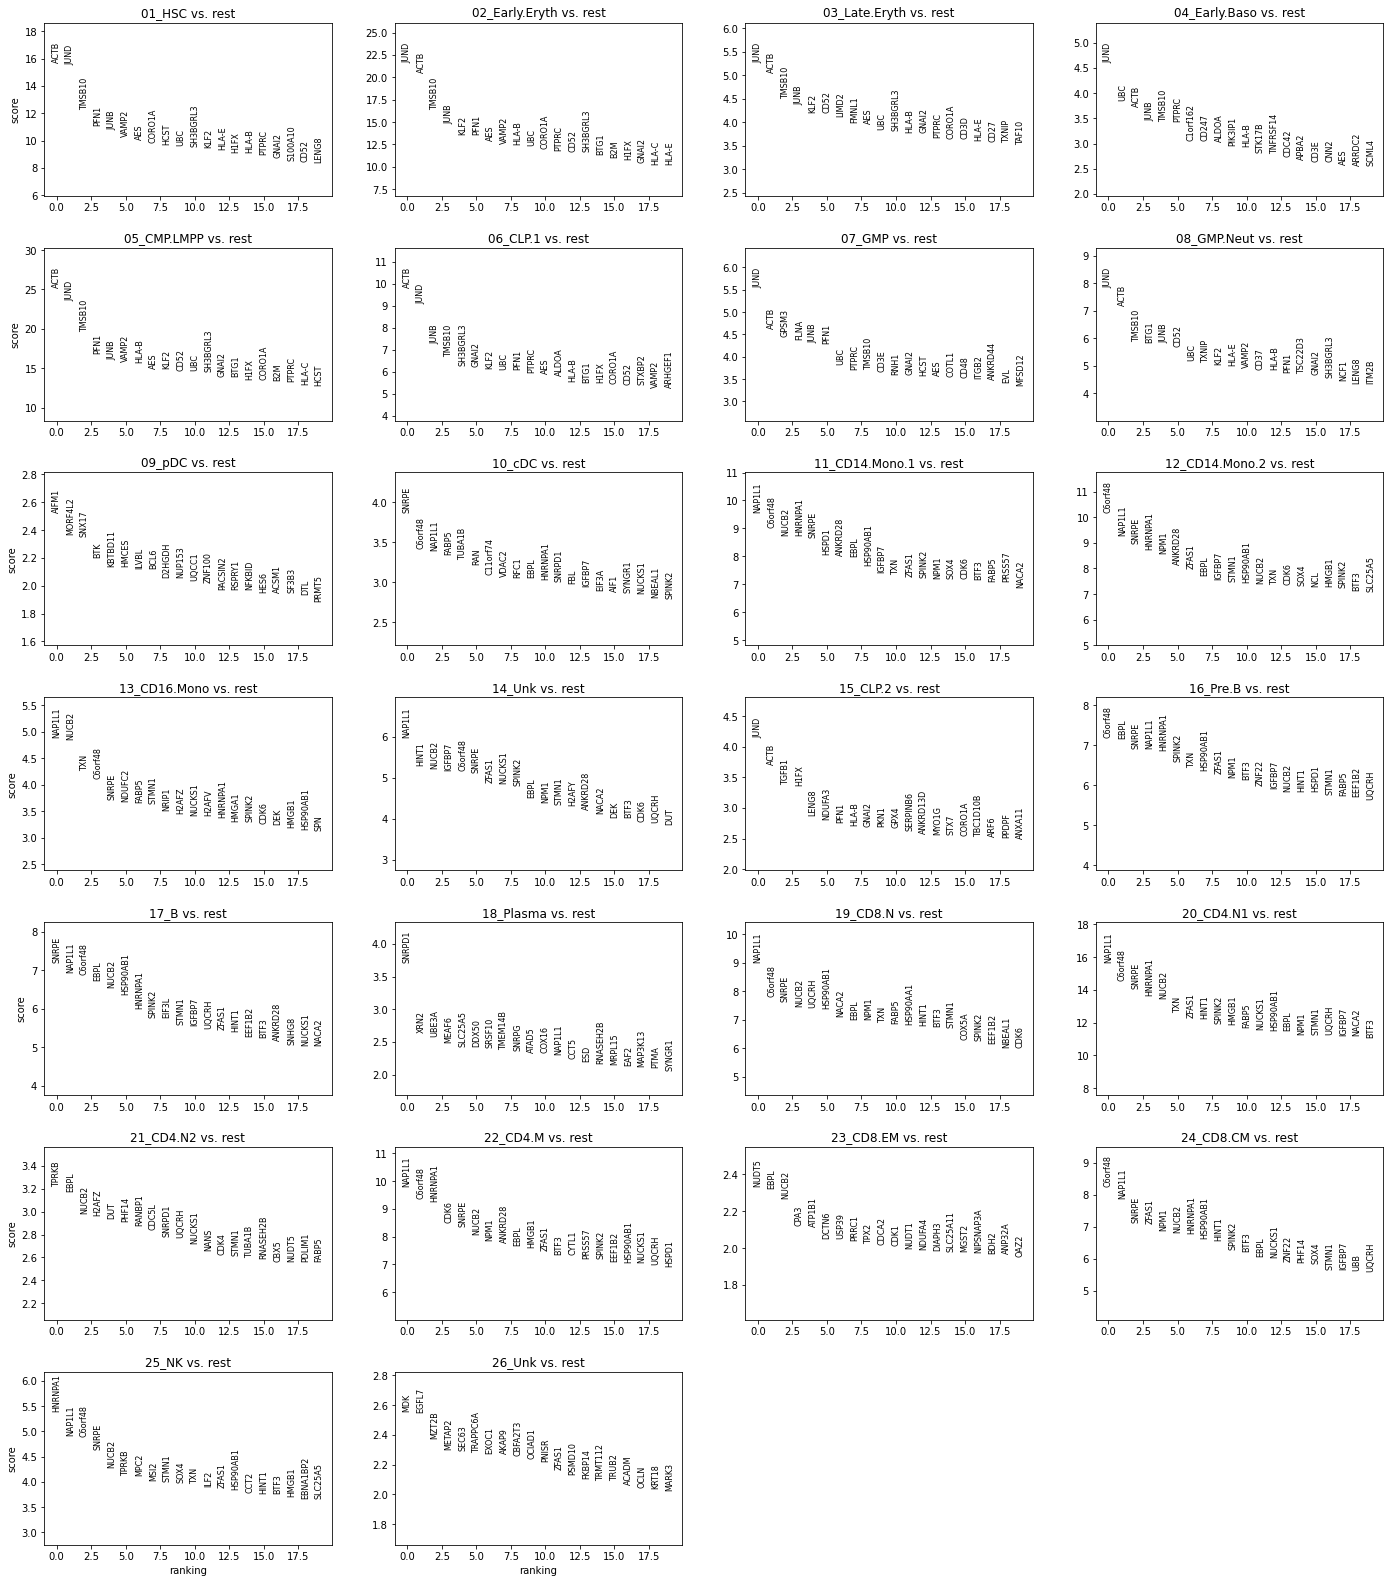

In [27]:
# Identify which genes are differentially expressed by the 2 unknown categories to try figure out what they are
sc.tl.rank_genes_groups(adata, groupby='BioClassification', key_added = 'rank_genes_unk', use_raw=False)
sc.pl.rank_genes_groups(adata, key='rank_genes_unk', sharey=False)

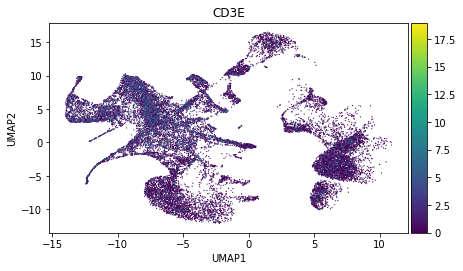

In [39]:
sc.pl.scatter(adata, x='UMAP1', y='UMAP2', color='CD3E')